# Model Tuning

Parameter tuning for Random Forest

# 1)-Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For data processing and maths
import numpy as np
import pandas as pd
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# 2)-Loading data

Source:https://www.kaggle.com/c/titanic

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


"NaN" is not a string, rather it's a special value: numpy.nan

In [5]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [6]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

**checking difference in features**

In [8]:
train.columns.difference(test.columns)

Index(['Survived'], dtype='object')

**Only target variable is difference**

# 3)- Exploring data

### 3.1)-Checking all variables with their data-type

In [9]:
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(train)
table_dtype

,Data Type
PassengerId,int64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Age,float64
Fare,float64
Name,object
Sex,object
Ticket,object


### 3.2)- Checking missing values

In [10]:
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

In [11]:
missing_values = find_missing_values(train, columns=train.columns)
missing_values

Number of missing or NaN values for each column:


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [12]:
missing_values = find_missing_values(test, columns=test.columns)
missing_values

Number of missing or NaN values for each column:


{'PassengerId': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 86,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 1,
 'Cabin': 327,
 'Embarked': 0}

**Treating missing values**

remove ‘Cabin’, ‘Name’ and ‘Ticket’ columns as they require some processing to extract useful features

In [13]:
train.pop('Cabin')
train.pop('Name')
train.pop('Ticket')
train.shape

(891, 9)

In [14]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

**Fill the missing age values by the mean value**

In [15]:
train['Age'] = train['Age'].fillna(train['Age'].mean())

**Fill the missing ‘Embarked’ values by the most frequent value**

In [16]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

**‘Pclass’ is a categorical feature so we convert its values to strings**

In [17]:
train['Pclass'] = train['Pclass'].apply(str)

### 3.3)-Dealing with categorical variables

one hot encoding of categorical features

In [18]:
# Getting Dummies from all other categorical vars
for col in train.dtypes[train.dtypes == 'object'].index:
    for_dummy = train.pop(col)
    train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [19]:
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


# 4)- Model

In [20]:
#pop() is an inbuilt function in Python that removes and returns last value from the list or the given index value
labels = train.pop('Survived')

In [21]:
labels[:5]

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### 4a)-train-test split

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)

### 4b) fit the model

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
y_pred = rf.predict(x_test)

### 4c)-Evaluation

We will use AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it’s a binary classification problem. AUC is a good way for evaluation for this type of problems.

In [25]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7806175402179555

Clearly it is overfitting. Let's tune model to get better outcome

# 5)- Model Tuning

### N_estimators
n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

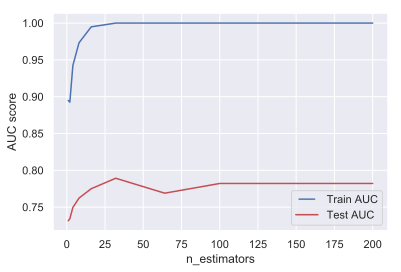

In [26]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

We can see that for our data, we can stop at 32 trees as increasing the number of trees decreases the test performance.

### max_depth
max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 32 and plot the training and test errors.

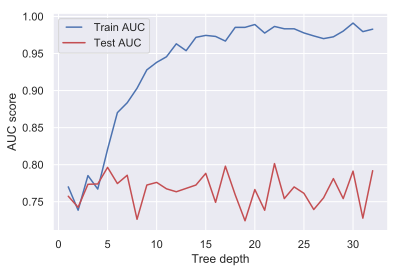

In [27]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that our model overfits for large depth values. The trees perfectly predicts all of the train data, however, it fails to generalize the findings for new data

### min_samples_split
min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

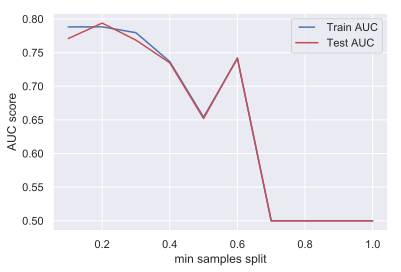

In [28]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

We can clearly see that when we require all of the samples at each node, the model cannot learn enough about the data. This is an underfitting case.

### min_samples_leaf
min_samples_leaf is The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.

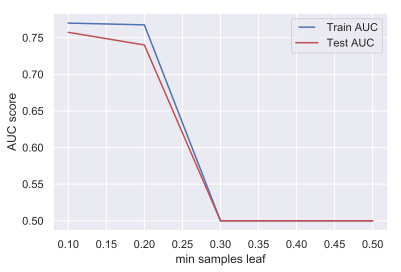

In [29]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

Same conclusion as to previous parameter. Increasing this value can cause underfitting.

### max_features
max_features represents the number of features to consider when looking for the best split.

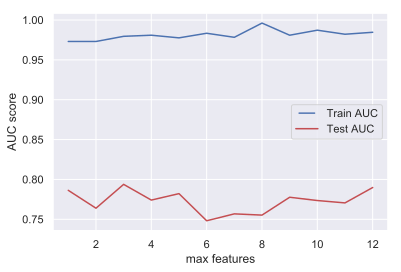

In [30]:
max_features = list(range(1,train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

This is also an overfitting case. It’s unexpected to get overfitting for all values of max_features. However, according to sklearn documentation for random forest, the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.